# Data Cleaning and Transformation
**Transforming Essays using word2vec and Creating Average Representation Vectors of Essays** 

In [1]:
%%capture
from requiredimports import *
from dataloading import *
%matplotlib inline

Thankfully, much of the data cleaning and collection was done in preparation for the project. Our goal is to convert the essays to vector representations as an average of the words of the essays, using word2vec neural network. 

An issue with working with large amounts of text data is that it results in sparse word representations. This can lead to high computation times due to the large amount of features. **word2vec** works well here converts text to a vector representation to the size of one's choosing and trained on text of our choosing. **word2vec** is the current standard for essentially a dimensionality reduction for text. The lower space groups similar words together, which improves modeling for both supervised and unsupervised learning methods. 

**word2vec** was an algorithm created at Google. It uses a shallow 2 layer neural network to assign vector representations of words by forming linguistic context of words. We'll see later in these sections how these word embeddings and context of words. 

**Data Cleaning and Transformation**

We start by converting the essays to a bag of words models. This works by removing all the stop words from the essays, for example: the, a , an, by, etc. These are mainly articles, prepositions, pronouns. After having removed the stopwords, we create a bag of words by creating a vocabulary of words and then create feature vectors of sentence. 

In [2]:
def essay_to_wordlist(essay_v, remove_stopwords):
    essay_v = re.sub("[^a-zA-Z]", " ", essay_v)
    words = essay_v.lower().split()    
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    return (words)

tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

def essay_to_sentences(essay_v, remove_stopwords):
    raw_sentences = tokenizer.tokenize(essay_v.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(essay_to_wordlist(raw_sentence, remove_stopwords))
    return sentences

In [3]:
sentences = []

print ("Parsing sentences from all the Essays")
for essay_v in df_all["essay"]:
    sentences += essay_to_sentences(essay_v, remove_stopwords = True)
    
print ("Complete")

Parsing sentences from all the Essays
Complete


After creating a bag of word model for all the essays, we use the **word2vec** package to create a model so that each word has dimensions of 300 features. 

There are few other parameters we use to create a model. 

**Minimum Word Count**: This value decides a minimum word count requried, meaning that words with a word count below this value is ignored. 

**Context**: This value takes in context of words used to create the vector representations. 

**Number of Features**: This value decides the number of features of for a word. 

In [4]:
%%capture
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

num_features = 300 
min_word_count = 40
num_workers = 4
context = 10
downsampling = 1e-3

model = word2vec.Word2Vec(sentences, workers=num_workers, size=num_features, min_count = min_word_count, window = context, sample = downsampling)
model.init_sims(replace=True)

model_name = "300features_40minwords_10context"
model.save(model_name)

**Word Embedding Visualization**

It is important to examine word embedding and see how words cluster together based on our word2vec model! To visualize this, we'll apply Prinicipal Component Analysis and reduce the word dimensionality to 2 componenets. We use the transformed word vectors and represent them on a 2D plot. We examine the top 25 most similar words to a word of our choice. 

Let's see how these words cluster together!

In [5]:
def viswordembedding(word_to_use, topn_):
    okay = model.most_similar(word_to_use, topn = topn_)
    words_to_show = [word_to_use]
    words_vec = np.zeros((topn_+1, 300))
    words_vec[0,:] = model[word_to_use]

    for ii in range(0, len(okay)):
        words_to_show.append(okay[ii][0])    
        words_vec[ii+1,:] = model[okay[ii][0]]

    pca = PCA(n_components=2)
    pca.fit(words_vec)
    X = pca.transform(words_vec)
    xs = X[:, 0]
    ys = X[:, 1]

    plt.figure(figsize=(8,6))
    plt.scatter(xs, ys, marker = 'o')
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    plt.title('Word Embedding Nearest Neighbors for ' + word_to_use)
    for i, w in enumerate(words_to_show):
        plt.annotate(
            w,
            xy = (xs[i], ys[i]), xytext = (3, 3),
            textcoords = 'offset points', ha = 'left', va = 'top')
    plt.savefig('wordembedding', bbox_inches = "tight")

Below we examine the 25 nearest neighbors to the word "time". What's most interesting is that the units of time cluster together in lower left corner of the plot i.e. hours, days, weeks, years. This is all decided by context of the words! 

A few other clusters are activities such as exercising, enjoying, outdoors - in the lower right corner of the graph. 

What's most interesting is the top most clusters. the words patience, patient cluster together as nearest neighbours for time!

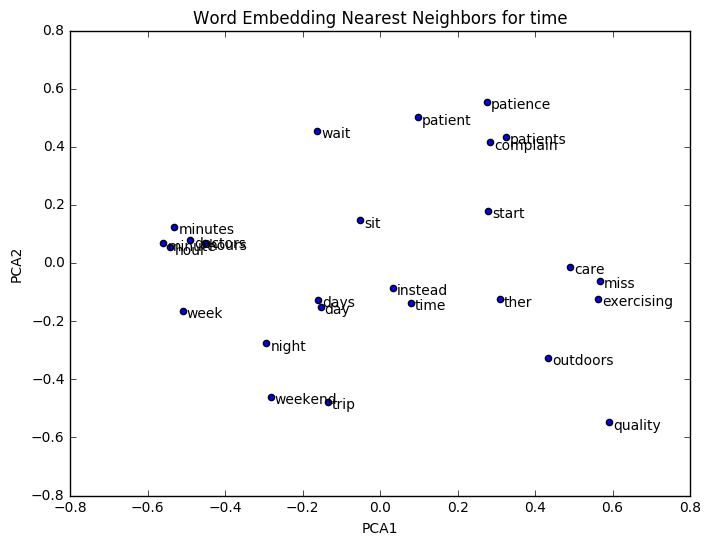

In [6]:
viswordembedding('time', 25)

Next we examine the nearest neighbors of the word "happy". Almost all the words are the nearest neighbours are adjectives, and synonyms of the word "happy". 

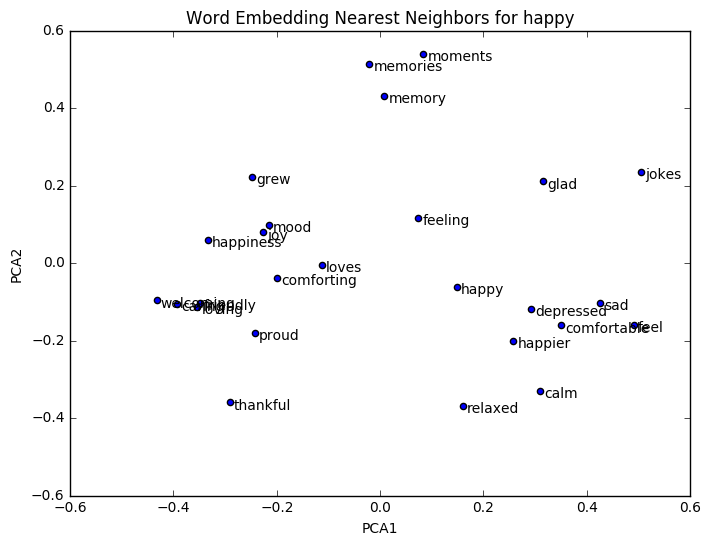

In [7]:
viswordembedding('happy', 25)

Lastly, we examine the nearest neighbours of the word "play". There are some interesting clusters that form here. In the lower right corner, sports are clustered together such as basketball, soccer, baseball. 

Another interesting cluster is the one in the upper right corner, words such as tv, youtube, download, videos cluster together as nearest neighbours of the word "play".

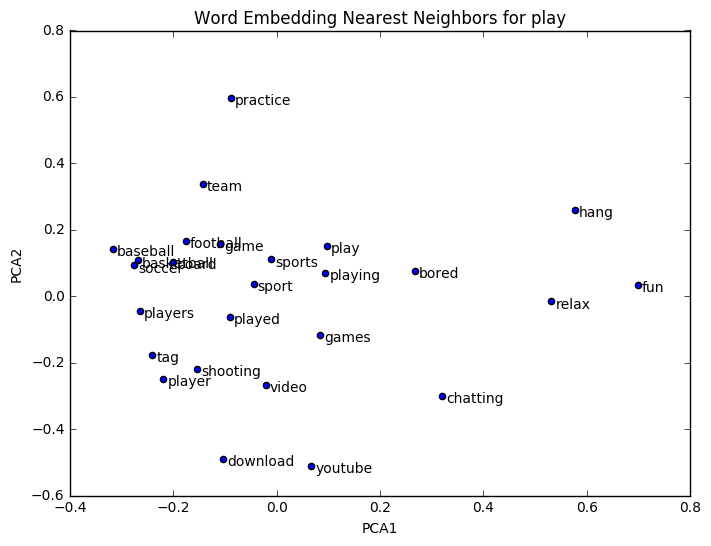

In [8]:
viswordembedding('play', 25)

**Create Average Feature Vectors for Essays**

For our analysis, we have to create averaged feature vectors of the words of each essay. We do this by using two functions **makeFeatureVec** and **getAvgFeatureVecs**. 

**makeFeatureVec** takes an essay and converts each word to vector representation using the earlier created word2vec model. Each word vector representation is added together and then averaged by diving by the number of words of the essay. This way each essay results in a vector with 300 features that is an average of each of the words in the essay. 

**getAvgFeatureVecs** creates vectors for essays for the entire dataset using **makeFeatureVec** function. 

In [9]:
def makeFeatureVec(words, model, num_features):
    featureVec = np.zeros((num_features,),dtype="float32")
    nwords = 0.
    index2word_set = set(model.index2word)
    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1.
            featureVec = np.add(featureVec,model[word])        
    featureVec = np.divide(featureVec,nwords)
    return featureVec

def getAvgFeatureVecs(essays, model, num_features):
    counter = 0.
    essayFeatureVecs = np.zeros((len(essays),num_features),dtype="float32")
    for essay in essays:
        essayFeatureVecs[counter] = makeFeatureVec(essay, model, num_features)
        counter = counter + 1.
    return essayFeatureVecs

In [10]:
print ("Creating average feature vecs for all Essays")

clean_essays = []
for essay_v in df_all["essay"]:
    clean_essays.append(essay_to_wordlist(essay_v, remove_stopwords=True ))
essayDataVecs = getAvgFeatureVecs(clean_essays, model, num_features )

print ("Complete")

Creating average feature vecs for all Essays
Complete


**Principal Component Analysis of Vectorized Essays**

Below we perform an analysis similar to the word embedding earlier. We use the feature vectors and perform PCA analysis and plot the essays on a 2D plot. Each essay vector is colored based on what grade it has. Below we have 8 plots for each essay set. 

Just a visualization of the essays for each PCA set does not result in a significant result or conclusion as the essays with different grades have significant overlap. Hopefully our models can better predict the results!

In [11]:
def visessay(set_no):
    
    indices = df_all[df_all['essay_set'] == set_no].index.tolist()
    
    if set_no == 8:
        indices = [i - 1 for i in indices]

    splicedDataVecs = essayDataVecs[indices,:]
    splicedGrades = np.array(df_all['domain1_score'][indices])
    
    n_grades = np.unique(splicedGrades)
    n = len(n_grades)
    color=iter(cm.rainbow(np.linspace(0,1,n)))
    
    pca = PCA(n_components=2)
    X = pca.fit_transform(splicedDataVecs)
    xs = X[:, 0]
    ys = X[:, 1]
    
    plt.figure(figsize=(6,4))
    
    for ii in range(n):
        index_ = [w for w in range(len(splicedGrades)) if splicedGrades[w] == n_grades[ii]]
        c = next(color)
        xs_ = xs[index_]
        ys_ = ys[index_]
        plt.scatter(xs_, ys_, marker = 'o', color = c)
        plt.title('PCA Plot of Essay Set ' + str(set_no))
        plt.xlabel('PCA1')
        plt.ylabel('PCA2')

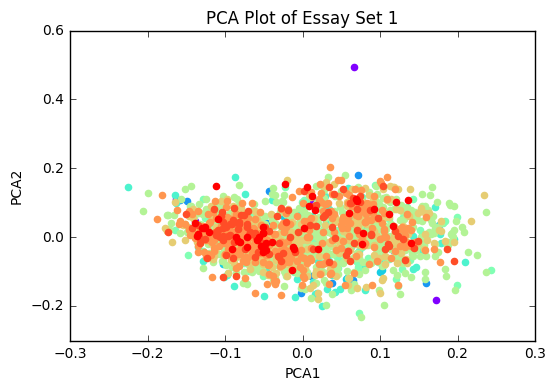

In [12]:
visessay(set_no = 1)

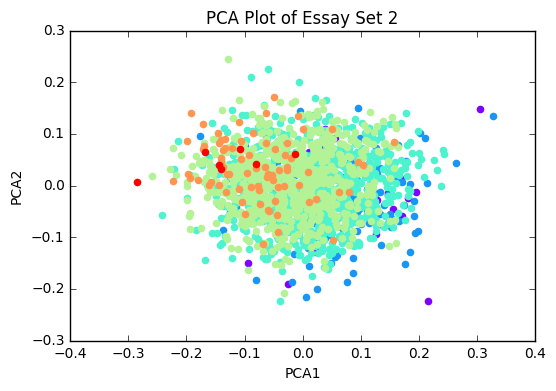

In [13]:
visessay(set_no = 2)

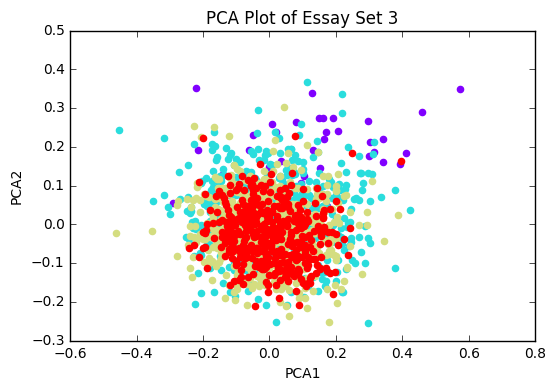

In [14]:
visessay(set_no = 3)

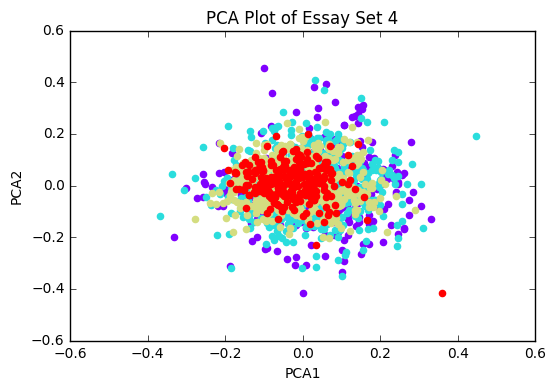

In [15]:
visessay(set_no = 4)

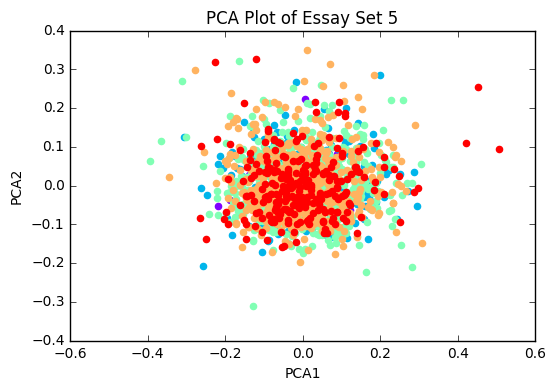

In [16]:
visessay(set_no = 5)

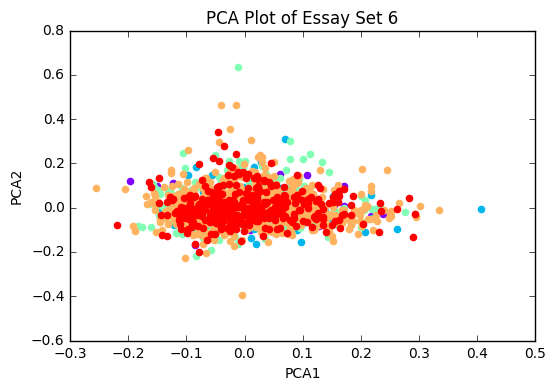

In [17]:
visessay(set_no = 6)

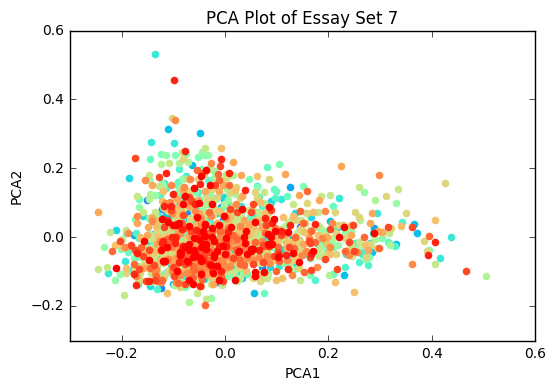

In [18]:
visessay(set_no = 7)

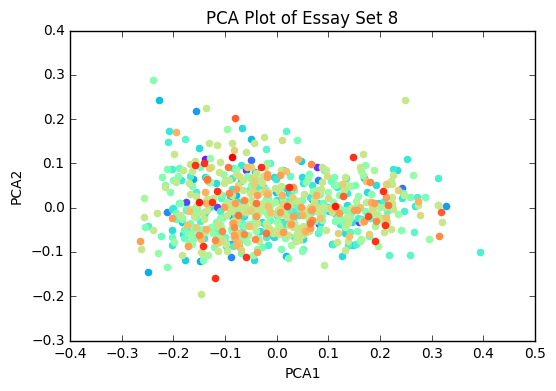

In [19]:
visessay(set_no = 8)